# Social Networks and Online Markets, Homework 1
###Author: Christian Buda
# Problem 5

In [ ]:
# install pytorch geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from tqdm.notebook import tqdm
import copy
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import networkx as nx

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.nn import SAGEConv

# The Dataset
The dataset consists of people and friendship relations between them in Pokec, the most popular Slovak on-line social network. These datasets
are anonymized and contains relationships and user profile data of the
whole network. Profile data are in Slovak language. Friendships in the
Pokec network are oriented. Datasets were crawled during MAY 25-27 2012.

Source: https://snap.stanford.edu/data/soc-Pokec.html

In [ ]:
# download and unzip data
!wget https://snap.stanford.edu/data/soc-pokec-relationships.txt.gz
!wget https://snap.stanford.edu/data/soc-pokec-profiles.txt.gz

!gunzip soc-pokec-relationships.txt.gz
!gunzip soc-pokec-profiles.txt.gz

--2023-06-10 16:44:12--  https://snap.stanford.edu/data/soc-pokec-relationships.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132454730 (126M) [application/x-gzip]
Saving to: ‘soc-pokec-relationships.txt.gz’

soc-pokec-relations 100%[===================>] 126.32M  15.0MB/s    in 21s     

2023-06-10 16:44:33 (6.16 MB/s) - ‘soc-pokec-relationships.txt.gz’ saved [132454730/132454730]

--2023-06-10 16:44:33--  https://snap.stanford.edu/data/soc-pokec-profiles.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435512787 (415M) [application/x-gzip]
Saving to: ‘soc-pokec-profiles.txt.gz’

soc-pokec-profiles. 100%[===================>] 415.34M  14.4MB/s    in 39s     

2023-0

# Data preparation
Let's start by loading and preprocessing the data. The interesting node features are the first 8 columns of the dataset, the remaining columns consists of optional additional information on each user, which I decided to not use.

In [ ]:
# load data
node_feat = pd.read_csv('soc-pokec-profiles.txt', sep = '\t', header = None, usecols = range(8))
edge_list = pd.read_csv('soc-pokec-relationships.txt', sep = '\t', header = None, names = ['Source', 'Target'])

# rename the columns and remove the region column
colnames = dict(zip(range(8),['user_id','public','completion_percentage','gender','region','last_login','registration','AGE']))
node_feat.rename(columns=colnames, inplace = True)
node_feat.drop(['region'], inplace = True, axis = 1)

In the data readme you can read:

*There are 163 records without any data and completion_percentage=0. (I think that these are the profiles of people who have canceled their accounts during the data crawling.)*

For this reason, I removed these 163 nodes from the graph. I also decided to remove the people for which the age attribute was not set. Finally, since the dataset is fairly big (about 1100000 nodes), I selected a random subset of 7000000 nodes to be able to train each model without incurring into memory issues.

In [ ]:
# remove cancelled accounts
nodes_to_be_removed = node_feat.loc[node_feat.gender.isna()].index
edges_to_be_removed1 = edge_list[edge_list['Source'].isin(node_feat.loc[nodes_to_be_removed, 'user_id'])].index
edges_to_be_removed2 = edge_list[edge_list['Target'].isin(node_feat.loc[nodes_to_be_removed, 'user_id'])].index

node_feat.drop(nodes_to_be_removed, inplace = True, axis = 0)
edge_list.drop(edges_to_be_removed1, inplace = True, axis = 0)
edge_list.drop(edges_to_be_removed2, inplace = True, axis = 0, errors = 'ignore')

# remove people without age attribute
# in the readme it says that 0 means age attribute not set
nodes_to_be_removed = node_feat.loc[node_feat.AGE==0].index
edges_to_be_removed1 = edge_list[edge_list['Source'].isin(node_feat.loc[nodes_to_be_removed, 'user_id'])].index
edges_to_be_removed2 = edge_list[edge_list['Target'].isin(node_feat.loc[nodes_to_be_removed, 'user_id'])].index

node_feat.drop(nodes_to_be_removed, inplace = True, axis = 0)
edge_list.drop(edges_to_be_removed1, inplace = True, axis = 0)
edge_list.drop(edges_to_be_removed2, inplace = True, axis = 0, errors = 'ignore')

# select only 700000 nodes to work with
np.random.seed(42)
remaining = np.random.choice(len(node_feat), size=700000, replace=False)
node_feat = pd.DataFrame(node_feat.iloc[remaining])
edge_list = pd.DataFrame(edge_list.loc[edge_list['Source'].isin(node_feat['user_id']) & edge_list['Target'].isin(node_feat['user_id'])])

# reset the indices
node_feat.reset_index(drop = True, inplace = True)
node_feat.reset_index(drop = False, inplace = True)
node_feat.set_index('user_id', inplace = True, drop = False)
edge_list.reset_index(drop = True, inplace = True)

# relabel the edges to make them refer to the position of the node in the node_feat object
edge_list = edge_list.apply(lambda x: node_feat.loc[x, 'index'].to_numpy(), axis = 0)

# convert datetime columns into timestamps to be used as features
node_feat.gender = node_feat.gender.astype('int')
node_feat.last_login = pd.to_datetime(node_feat.last_login, format='%Y-%m-%d %H:%M:%S').view('int64')
node_feat.registration = pd.to_datetime(node_feat.registration, format='%Y-%m-%d %H:%M:%S').view('int64')

# normalize the data
mean_ts = node_feat[['last_login', 'registration']].to_numpy().mean()
sd_ts = node_feat[['last_login', 'registration']].to_numpy().std()

node_feat['last_login'] = node_feat['last_login'].apply(lambda x: (x-mean_ts)/sd_ts)
node_feat['registration'] = node_feat['registration'].apply(lambda x: (x-mean_ts)/sd_ts)
node_feat['completion_percentage'] = (node_feat['completion_percentage'] - node_feat['completion_percentage'].mean())/node_feat['completion_percentage'].std()

I would like to predict the age range of each node (since it seems to be the kind of target feature that may benefit from the added information of the network structure); so let's have a look at the age distribution:

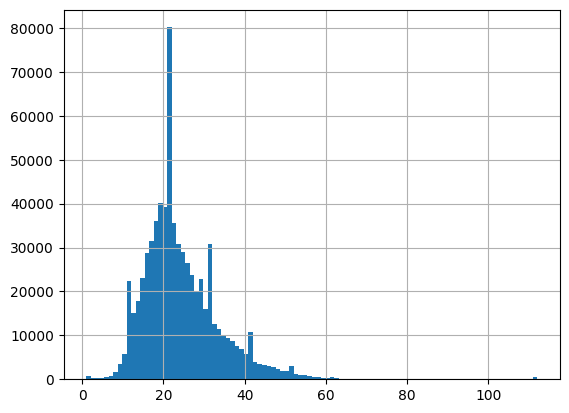

In [ ]:
node_feat.AGE.hist(bins = 100)
plt.show()

The first split is pretty natural, I will take as one of the labels the people under 20. The second split is more of an experiment (I tried different combinations but I decided to go with a more balanced approach): I chose to consider the people over 30.

In [ ]:
# create labels
node_feat['label'] = 1  # between 20 and 40
node_feat.loc[node_feat.AGE < 20, 'label'] = 0 # under 20
node_feat.loc[node_feat.AGE > 30, 'label'] = 2 # over 30

# remove useless columns
node_feat.drop(['index',	'user_id', 'AGE'], axis = 1, inplace = True)

Here we can see the final node features and the structure of the edge list.

In [ ]:
# Final node features
node_feat.head(5)

,public,completion_percentage,gender,last_login,registration,label
user_id,,,,,,
23048,1,0.605095,1,0.741399,-1.322167,0
540332,1,-1.165534,0,0.526092,-0.243952,1
96727,1,1.181579,1,0.741426,-2.015305,0
212501,0,-1.165534,1,0.657523,-1.003442,2
532887,1,1.263934,0,0.740255,0.636392,0


In [ ]:
# edge list structure
edge_list.head(5)

,Source,Target
0,195922,547576
1,195922,56136
2,195922,364335
3,195922,124657
4,195922,210943


And finally, we load the dataset in Pytorch Geometric. In doing this, I split randomly the nodes into train, validation and test.

In [ ]:
# load data in PyG
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch_geometric.seed_everything(420)
# split in train, test and validation
mask = RandomNodeSplit(split="train_rest", num_splits = 1, num_val = 0.3, num_test= 0.5, key = 'y')

edge_index = torch.tensor(edge_list.to_numpy(), dtype=torch.long)
x = torch.tensor(node_feat[['public','completion_percentage','gender','last_login','registration']].to_numpy(), dtype=torch.float)
y = torch.tensor(node_feat['label'].to_numpy(), dtype=torch.long)

pyg_graph = Data(x=x, y = y, edge_index=edge_index.t().contiguous())
pyg_graph.num_classes = 3

# move data on the processing unit memory and apply the split
data = pyg_graph.to(device)
data = mask(data)

# Data exploration
Here I show a quick summary of the dataset. We can see below the class distribution; the dataset is not balanced but it's not badly unbalanced either.

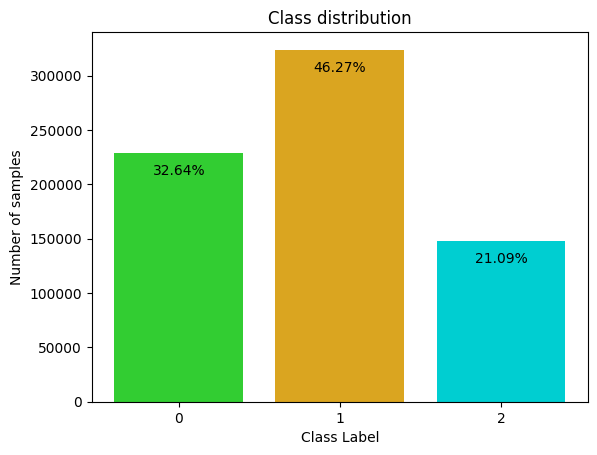

In [ ]:
unique_labels, counts = np.unique(node_feat['label'], return_counts=True)

plt.bar(unique_labels, counts, color = ['limegreen', 'goldenrod', 'darkturquoise'])
plt.xlabel('Class Label')
plt.ylabel('Number of samples')
plt.title('Class distribution')
plt.xticks(range(3))
plt.text(0, counts[0]-10000, f'{100*(counts/len(node_feat))[0]:.2f}%', ha='center', va='top')
plt.text(1, counts[1]-10000, f'{100*(counts/len(node_feat))[1]:.2f}%', ha='center', va='top')
plt.text(2, counts[2]-10000, f'{100*(counts/len(node_feat))[2]:.2f}%', ha='center', va='top')
plt.show()

In [ ]:
# Make a networkx graph to perform some basic analysis
G = nx.DiGraph()
G.add_nodes_from(range(len(node_feat)))
G.add_edges_from(edge_list.to_numpy())


# find all the weakly and the strongly connected components
wcc = list(nx.weakly_connected_components(G))
scc = list(nx.strongly_connected_components(G))
n_wcc = len(wcc)
n_scc = len(scc)

wcc = G.subgraph(max(wcc, key=len))
scc = G.subgraph(max(scc, key=len))

In [ ]:
print()
print(f'Dataset: {data}:')
print('======================')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of Weakly Connected Components: {n_wcc}')
print(f'Number of nodes in largest Weakly Connected Components: {len(wcc.nodes)}')
print(f'Number of edges in largest Weakly Connected Components: {len(wcc.edges)}')
print(f'Number of Strongly Connected Components: {n_scc}')
print(f'Number of nodes in largest Strongly Connected Components: {len(scc.nodes)}')
print(f'Number of edges in largest Strongly Connected Components: {len(scc.edges)}')
print(f'Number of training nodes: {data.train_mask.sum()}, {(int(data.train_mask.sum()) / data.num_nodes)*100:.0f}%')
print(f'Number of validation nodes: {data.val_mask.sum()}, {(int(data.val_mask.sum()) / data.num_nodes)*100:.0f}%')
print(f'Number of testing nodes: {data.test_mask.sum()}, {(int(data.test_mask.sum()) / data.num_nodes)*100:.0f}%')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is directed: {data.is_directed()}')


Dataset: Data(x=[700000, 5], edge_index=[2, 5656188], y=[700000], num_classes=3, train_mask=[700000], val_mask=[700000], test_mask=[700000]):
Number of features: 5
Number of classes: 3
Number of nodes: 700000
Number of edges: 5656188
Average node degree: 8.08
Number of Weakly Connected Components: 70886
Number of nodes in largest Weakly Connected Components: 626901
Number of edges in largest Weakly Connected Components: 5653187
Number of Strongly Connected Components: 231746
Number of nodes in largest Strongly Connected Components: 464557
Number of edges in largest Strongly Connected Components: 5204834
Number of training nodes: 140000, 20%
Number of validation nodes: 210000, 30%
Number of testing nodes: 350000, 50%
Has isolated nodes: True
Has self-loops: False
Is directed: True


We can see that the largest weakly connected component covers the vast majority of the graph, while the largest strongly connected component is much smaller.

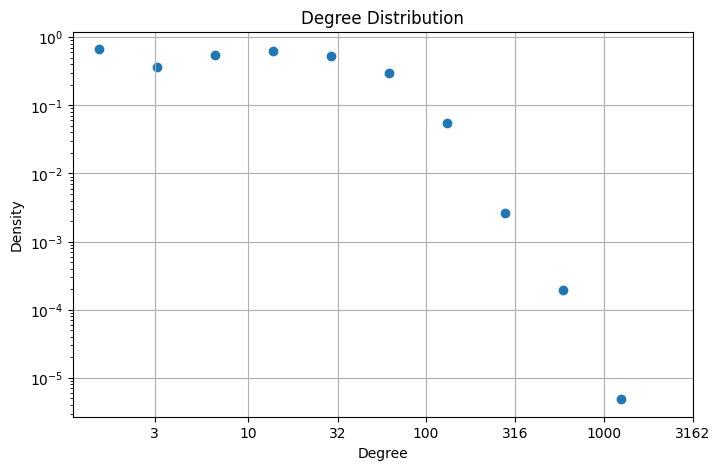

In [ ]:
# --log log degree distribution plot--

# compute degree distribution
degree_hist = np.sort(np.array(list(dict(G.degree()).values())))[::-1]
degree_hist = degree_hist[degree_hist > 0]  # remove isolated nodes
log_degree = np.log10(degree_hist)
y,x = np.histogram(log_degree, density = True, bins = 10)
x = (x[:-1] + x[1:])/2

fig, ax2 = plt.subplots(figsize=(8, 5))

ax2.scatter(x, y)
ax2.set_yscale('log')
xt = ax2.get_xticks()
xt = xt[xt>0]
xt = 10**(xt)
xt = np.round(xt).astype(int)
ax2.set_xticks(np.log10(xt), labels = xt)
ax2.grid()
ax2.set_title("Degree Distribution")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Density")
plt.show()

From the histogram of the degree distribution, we can visually see that the graph is asymptotically scale-free.

# The models
We will consider 4 different architectures:

*   A simple MLP over the node features
*   A Graph Convolutional Network
*   A Graph SAGE Convolutional Network
*   A Graph Attention Network

These 4 architecture will be used in a very similar 2-layer fashion. A cross-entropy loss for multiclass classificarion will be used, and the number of hidden units will be chosen among various configurations.

In [ ]:
class MLP(torch.nn.Module):
  def __init__(self, n_channels, data):
    super().__init__()
    self.lin1 = Linear(data.num_features, n_channels)
    self.lin2 = Linear(n_channels, data.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.lin1(x)
    x = x.relu()
    x = F.dropout(x, training=self.training)
    x = self.lin2(x)

    return F.log_softmax(x, dim=1)

class GCN(torch.nn.Module):
  def __init__(self, n_channels, data):
    super().__init__()
    self.conv1 = GCNConv(data.num_node_features, n_channels)
    self.conv2 = GCNConv(n_channels, data.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

class GCNSage(torch.nn.Module):
  def __init__(self, n_channels, data):
    super().__init__()
    self.conv1 = SAGEConv(data.num_node_features, n_channels)
    self.conv2 = SAGEConv(n_channels, data.num_classes)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
  def __init__(self, n_channels, data):
    super().__init__()
    self.conv1 = GATConv(data.num_node_features, n_channels, heads = 8)
    self.conv2 = GATConv(n_channels * 8, data.num_classes, heads = 1)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = F.dropout(x, training=self.training)
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x, training=self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x, dim=1)

# Training!
To train the models I used a fixed learning rate with a bit of weight decay over a maximum of 200 epochs. The optimizer used is Adam, and the preferred evaluation metric will simply be the accuracy. The models were trained with early stopping by monitoring the validation accuracy, with a patience of 15 epochs.


In [ ]:
class EarlyStopping():
  # early stopping object
  def __init__(self, patience=5, high = True):
    self.patience = patience

    # high tells wether we want the input metric to be high or low for the model
    # e.g. accuracy vs loss
    if high:
      self.mode = 1
    else:
      self.mode = -1

    self.count = 0
    self.best_score = -np.Inf
    self.stop = False
  
  def __call__(self, model, metric):
    # current score
    score = self.mode * metric
    
    if score < self.best_score:
      # we already have a good model, keep waiting
      self.count += 1

      if self.count >= self.patience:
        # waited enough, early stop!! 
        self.stop = True
    else:
      # update best model
      self.best_score = score
      self.best_model = copy.deepcopy(model.state_dict())
      self.count = 0


def train_step(model, data, loss_fn, optimizer, metric):
  # single training step

  model.train()
  optimizer.zero_grad()
  out = model(data)
  loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  # compute training metrics
  pred = out[data.val_mask].argmax(dim = 1)
  acc = metric(pred, data.y[data.val_mask])
  return(loss.item(), acc)


def evaluate(model, data, loss_fn, metric):
  # evaluate the model on the validation set

  model.eval()

  with torch.no_grad():
    out = model(data)
    loss = loss_fn(out[data.val_mask], data.y[data.val_mask])

    pred = out[data.val_mask].argmax(dim = 1)
    acc = metric(pred, data.y[data.val_mask])

  return loss.item(), acc


def train(model, data, loss_fn, optimizer, metric, patience = 10, verbose = True):
  # perform training

  # initialize early stopping
  early_stopping = EarlyStopping(patience=patience, high = True)

  for epoch in tqdm(range(epochs)):
    # Train for one epoch
    train_loss, train_acc = train_step(model, data, loss_fn, optimizer, metric)
    
    # Evaluate on validation set
    val_loss, val_acc = evaluate(model, data, loss_fn, metric)
    
    # Check for early stopping
    early_stopping(model, val_acc)

    if verbose:
      print('epoch {:03d}, train_loss {:.4f}, train_accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}'.format(epoch, train_loss, train_acc, val_loss, val_acc))
    if early_stopping.stop:
      print(f"Early stopping. Restoring the model at epoch {(epoch - patience):03d} with early stopping metric {early_stopping.mode * early_stopping.best_score:.4f}.")
      break

  return

def test(model, data, loss_fn, metric):
  # evaluate the model on the test set

  model.eval()

  with torch.no_grad():
    out = model(data)
    loss = loss_fn(out[data.test_mask], data.y[data.test_mask])

    pred = out[data.test_mask].argmax(dim = 1)
    acc = metric(pred, data.y[data.test_mask])

  return loss.item(), acc

def metric(pred, target):
  # function used to compute the chosen accuracy metric

  test_correct = pred == target  # Check against ground-truth labels.
  test_acc = int(test_correct.sum()) / len(target)  # Derive ratio of correct predictions.

  return(test_acc)

In [ ]:
# set parameters
learning_rate = 0.01
weight_decay  = 5e-4
epochs        = 200
patience = 15

# values of hidden units to test
channel_vec = [8, 16, 32, 64, 128]
channel_vec_gat = [2, 4, 6, 8, 10]

# MLP---------------------------------------------------------------------------
MLP_loss = []
MLP_acc  = []
for n_channels in channel_vec:
  # empty free memory
  gc.collect()
  torch.cuda.empty_cache()

  print('Training MLP with', n_channels, 'hidden neurons------------------------')
  model = MLP(n_channels, data).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience)
  loss, acc = evaluate(model, data, loss_fn = F.nll_loss, metric = metric)

  # collect validation metrics
  MLP_loss.append(loss)
  MLP_acc.append(acc)

# GCN---------------------------------------------------------------------------
GCN_loss = []
GCN_acc  = []
for n_channels in channel_vec:
  # empty free memory
  gc.collect()
  torch.cuda.empty_cache()

  print('Training GCN with', n_channels, 'hidden channels------------------------')
  model = GCN(n_channels, data).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience)
  loss, acc = evaluate(model, data, loss_fn = F.nll_loss, metric = metric)

  # collect validation metrics
  GCN_loss.append(loss)
  GCN_acc.append(acc)

# GCNSage-----------------------------------------------------------------------
GCNSage_loss = []
GCNSage_acc  = []
for n_channels in channel_vec:
  # empty free memory
  gc.collect()
  torch.cuda.empty_cache()

  print('Training GCNSage with', n_channels, 'hidden channels------------------------')
  model = GCNSage(n_channels, data).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience)
  loss, acc = evaluate(model, data, loss_fn = F.nll_loss, metric = metric)

  # collect validation metrics
  GCNSage_loss.append(loss)
  GCNSage_acc.append(acc)

# GAT---------------------------------------------------------------------------
GAT_loss = []
GAT_acc  = []
for n_channels in channel_vec_gat:
  # empty free memory
  gc.collect()
  torch.cuda.empty_cache()

  print('Training GAT with', n_channels, 'hidden channels------------------------')
  model = GAT(n_channels, data).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience)
  loss, acc = evaluate(model, data, loss_fn = F.nll_loss, metric = metric)

  # collect validation metrics
  GAT_loss.append(loss)
  GAT_acc.append(acc)

Training MLP with 8 hidden neurons------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1525, train_accuracy 0.2898, val_loss 1.1199, val_accuracy 0.3154
epoch 001, train_loss 1.1377, train_accuracy 0.2922, val_loss 1.1087, val_accuracy 0.3178
epoch 002, train_loss 1.1241, train_accuracy 0.2951, val_loss 1.0986, val_accuracy 0.3205
epoch 003, train_loss 1.1126, train_accuracy 0.3003, val_loss 1.0896, val_accuracy 0.3266
epoch 004, train_loss 1.1028, train_accuracy 0.3040, val_loss 1.0815, val_accuracy 0.3430
epoch 005, train_loss 1.0935, train_accuracy 0.3117, val_loss 1.0741, val_accuracy 0.4075
epoch 006, train_loss 1.0862, train_accuracy 0.3265, val_loss 1.0675, val_accuracy 0.4424
epoch 007, train_loss 1.0798, train_accuracy 0.3420, val_loss 1.0615, val_accuracy 0.4866
epoch 008, train_loss 1.0739, train_accuracy 0.3851, val_loss 1.0562, val_accuracy 0.5100
epoch 009, train_loss 1.0686, train_accuracy 0.4059, val_loss 1.0513, val_accuracy 0.5090
epoch 010, train_loss 1.0644, train_accuracy 0.4376, val_loss 1.0467, val_accuracy 0.5100
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0846, train_accuracy 0.4279, val_loss 1.0528, val_accuracy 0.4628
epoch 001, train_loss 1.0709, train_accuracy 0.4487, val_loss 1.0398, val_accuracy 0.4665
epoch 002, train_loss 1.0580, train_accuracy 0.4631, val_loss 1.0291, val_accuracy 0.4748
epoch 003, train_loss 1.0489, train_accuracy 0.4719, val_loss 1.0205, val_accuracy 0.4840
epoch 004, train_loss 1.0414, train_accuracy 0.4781, val_loss 1.0136, val_accuracy 0.4920
epoch 005, train_loss 1.0358, train_accuracy 0.4796, val_loss 1.0082, val_accuracy 0.4952
epoch 006, train_loss 1.0317, train_accuracy 0.4813, val_loss 1.0040, val_accuracy 0.4964
epoch 007, train_loss 1.0285, train_accuracy 0.4834, val_loss 1.0009, val_accuracy 0.4971
epoch 008, train_loss 1.0252, train_accuracy 0.4826, val_loss 0.9985, val_accuracy 0.4973
epoch 009, train_loss 1.0219, train_accuracy 0.4841, val_loss 0.9968, val_accuracy 0.4974
epoch 010, train_loss 1.0200, train_accuracy 0.4852, val_loss 0.9956, val_accuracy 0.4977
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1318, train_accuracy 0.3472, val_loss 1.0775, val_accuracy 0.4174
epoch 001, train_loss 1.0956, train_accuracy 0.3900, val_loss 1.0517, val_accuracy 0.4688
epoch 002, train_loss 1.0695, train_accuracy 0.4302, val_loss 1.0361, val_accuracy 0.4641
epoch 003, train_loss 1.0554, train_accuracy 0.4515, val_loss 1.0278, val_accuracy 0.4627
epoch 004, train_loss 1.0473, train_accuracy 0.4612, val_loss 1.0229, val_accuracy 0.4627
epoch 005, train_loss 1.0442, train_accuracy 0.4660, val_loss 1.0185, val_accuracy 0.4627
epoch 006, train_loss 1.0402, train_accuracy 0.4680, val_loss 1.0134, val_accuracy 0.4641
epoch 007, train_loss 1.0358, train_accuracy 0.4717, val_loss 1.0075, val_accuracy 0.4718
epoch 008, train_loss 1.0290, train_accuracy 0.4764, val_loss 1.0016, val_accuracy 0.4804
epoch 009, train_loss 1.0226, train_accuracy 0.4822, val_loss 0.9963, val_accuracy 0.4942
epoch 010, train_loss 1.0168, train_accuracy 0.4876, val_loss 0.9920, val_accuracy 0.5011
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1613, train_accuracy 0.2652, val_loss 1.0920, val_accuracy 0.3786
epoch 001, train_loss 1.1061, train_accuracy 0.3557, val_loss 1.0556, val_accuracy 0.4647
epoch 002, train_loss 1.0699, train_accuracy 0.4330, val_loss 1.0339, val_accuracy 0.4688
epoch 003, train_loss 1.0491, train_accuracy 0.4689, val_loss 1.0211, val_accuracy 0.4846
epoch 004, train_loss 1.0388, train_accuracy 0.4818, val_loss 1.0126, val_accuracy 0.5023
epoch 005, train_loss 1.0310, train_accuracy 0.4900, val_loss 1.0059, val_accuracy 0.5053
epoch 006, train_loss 1.0252, train_accuracy 0.4980, val_loss 1.0000, val_accuracy 0.5082
epoch 007, train_loss 1.0194, train_accuracy 0.5025, val_loss 0.9949, val_accuracy 0.5109
epoch 008, train_loss 1.0143, train_accuracy 0.5057, val_loss 0.9907, val_accuracy 0.5128
epoch 009, train_loss 1.0111, train_accuracy 0.5072, val_loss 0.9873, val_accuracy 0.5149
epoch 010, train_loss 1.0063, train_accuracy 0.5089, val_loss 0.9851, val_accuracy 0.5165
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1885, train_accuracy 0.2729, val_loss 1.0581, val_accuracy 0.4623
epoch 001, train_loss 1.0728, train_accuracy 0.4305, val_loss 1.0396, val_accuracy 0.4627
epoch 002, train_loss 1.0545, train_accuracy 0.4655, val_loss 1.0342, val_accuracy 0.4664
epoch 003, train_loss 1.0486, train_accuracy 0.4728, val_loss 1.0150, val_accuracy 0.4867
epoch 004, train_loss 1.0300, train_accuracy 0.4879, val_loss 0.9946, val_accuracy 0.5075
epoch 005, train_loss 1.0102, train_accuracy 0.5035, val_loss 0.9848, val_accuracy 0.5154
epoch 006, train_loss 0.9999, train_accuracy 0.5112, val_loss 0.9855, val_accuracy 0.5179
epoch 007, train_loss 1.0006, train_accuracy 0.5137, val_loss 0.9896, val_accuracy 0.5188
epoch 008, train_loss 1.0038, train_accuracy 0.5133, val_loss 0.9918, val_accuracy 0.5193
epoch 009, train_loss 1.0042, train_accuracy 0.5106, val_loss 0.9908, val_accuracy 0.5198
epoch 010, train_loss 1.0018, train_accuracy 0.5102, val_loss 0.9875, val_accuracy 0.5196
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0070, train_accuracy 0.4988, val_loss 0.9757, val_accuracy 0.5286
epoch 001, train_loss 0.9980, train_accuracy 0.5108, val_loss 0.9687, val_accuracy 0.5414
epoch 002, train_loss 0.9894, train_accuracy 0.5242, val_loss 0.9626, val_accuracy 0.5483
epoch 003, train_loss 0.9847, train_accuracy 0.5303, val_loss 0.9572, val_accuracy 0.5515
epoch 004, train_loss 0.9787, train_accuracy 0.5370, val_loss 0.9527, val_accuracy 0.5534
epoch 005, train_loss 0.9733, train_accuracy 0.5400, val_loss 0.9489, val_accuracy 0.5550
epoch 006, train_loss 0.9699, train_accuracy 0.5416, val_loss 0.9457, val_accuracy 0.5560
epoch 007, train_loss 0.9672, train_accuracy 0.5439, val_loss 0.9432, val_accuracy 0.5566
epoch 008, train_loss 0.9656, train_accuracy 0.5449, val_loss 0.9411, val_accuracy 0.5572
epoch 009, train_loss 0.9623, train_accuracy 0.5462, val_loss 0.9393, val_accuracy 0.5575
epoch 010, train_loss 0.9622, train_accuracy 0.5465, val_loss 0.9379, val_accuracy 0.5578
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1126, train_accuracy 0.3427, val_loss 1.0740, val_accuracy 0.4185
epoch 001, train_loss 1.0940, train_accuracy 0.4018, val_loss 1.0608, val_accuracy 0.4629
epoch 002, train_loss 1.0809, train_accuracy 0.4505, val_loss 1.0496, val_accuracy 0.4672
epoch 003, train_loss 1.0670, train_accuracy 0.4609, val_loss 1.0401, val_accuracy 0.4701
epoch 004, train_loss 1.0566, train_accuracy 0.4645, val_loss 1.0321, val_accuracy 0.4735
epoch 005, train_loss 1.0485, train_accuracy 0.4670, val_loss 1.0254, val_accuracy 0.4767
epoch 006, train_loss 1.0404, train_accuracy 0.4702, val_loss 1.0195, val_accuracy 0.4801
epoch 007, train_loss 1.0347, train_accuracy 0.4732, val_loss 1.0143, val_accuracy 0.4838
epoch 008, train_loss 1.0289, train_accuracy 0.4749, val_loss 1.0095, val_accuracy 0.4849
epoch 009, train_loss 1.0245, train_accuracy 0.4780, val_loss 1.0051, val_accuracy 0.4870
epoch 010, train_loss 1.0205, train_accuracy 0.4800, val_loss 1.0010, val_accuracy 0.4888
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1101, train_accuracy 0.3304, val_loss 1.0584, val_accuracy 0.3766
epoch 001, train_loss 1.0723, train_accuracy 0.3873, val_loss 1.0320, val_accuracy 0.4912
epoch 002, train_loss 1.0461, train_accuracy 0.4694, val_loss 1.0131, val_accuracy 0.5036
epoch 003, train_loss 1.0263, train_accuracy 0.4905, val_loss 0.9991, val_accuracy 0.5009
epoch 004, train_loss 1.0123, train_accuracy 0.4955, val_loss 0.9883, val_accuracy 0.5030
epoch 005, train_loss 1.0021, train_accuracy 0.4984, val_loss 0.9791, val_accuracy 0.5085
epoch 006, train_loss 0.9935, train_accuracy 0.5030, val_loss 0.9707, val_accuracy 0.5165
epoch 007, train_loss 0.9844, train_accuracy 0.5102, val_loss 0.9629, val_accuracy 0.5253
epoch 008, train_loss 0.9769, train_accuracy 0.5184, val_loss 0.9560, val_accuracy 0.5342
epoch 009, train_loss 0.9704, train_accuracy 0.5281, val_loss 0.9506, val_accuracy 0.5442
epoch 010, train_loss 0.9644, train_accuracy 0.5363, val_loss 0.9471, val_accuracy 0.5515
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0752, train_accuracy 0.3653, val_loss 1.0190, val_accuracy 0.5079
epoch 001, train_loss 1.0316, train_accuracy 0.4924, val_loss 0.9970, val_accuracy 0.5208
epoch 002, train_loss 1.0103, train_accuracy 0.5065, val_loss 0.9837, val_accuracy 0.5282
epoch 003, train_loss 0.9969, train_accuracy 0.5158, val_loss 0.9723, val_accuracy 0.5325
epoch 004, train_loss 0.9850, train_accuracy 0.5229, val_loss 0.9624, val_accuracy 0.5368
epoch 005, train_loss 0.9767, train_accuracy 0.5292, val_loss 0.9550, val_accuracy 0.5422
epoch 006, train_loss 0.9674, train_accuracy 0.5353, val_loss 0.9504, val_accuracy 0.5461
epoch 007, train_loss 0.9651, train_accuracy 0.5403, val_loss 0.9479, val_accuracy 0.5505
epoch 008, train_loss 0.9607, train_accuracy 0.5437, val_loss 0.9456, val_accuracy 0.5536
epoch 009, train_loss 0.9597, train_accuracy 0.5451, val_loss 0.9427, val_accuracy 0.5560
epoch 010, train_loss 0.9564, train_accuracy 0.5470, val_loss 0.9396, val_accuracy 0.5596
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.2003, train_accuracy 0.2233, val_loss 1.0696, val_accuracy 0.4628
epoch 001, train_loss 1.0751, train_accuracy 0.4324, val_loss 1.0155, val_accuracy 0.4723
epoch 002, train_loss 1.0210, train_accuracy 0.4763, val_loss 1.0024, val_accuracy 0.4984
epoch 003, train_loss 1.0082, train_accuracy 0.4909, val_loss 0.9980, val_accuracy 0.5215
epoch 004, train_loss 1.0040, train_accuracy 0.5145, val_loss 0.9899, val_accuracy 0.5327
epoch 005, train_loss 0.9965, train_accuracy 0.5295, val_loss 0.9783, val_accuracy 0.5408
epoch 006, train_loss 0.9852, train_accuracy 0.5386, val_loss 0.9657, val_accuracy 0.5472
epoch 007, train_loss 0.9736, train_accuracy 0.5445, val_loss 0.9537, val_accuracy 0.5520
epoch 008, train_loss 0.9597, train_accuracy 0.5492, val_loss 0.9445, val_accuracy 0.5561
epoch 009, train_loss 0.9509, train_accuracy 0.5526, val_loss 0.9396, val_accuracy 0.5582
epoch 010, train_loss 0.9452, train_accuracy 0.5532, val_loss 0.9398, val_accuracy 0.5542
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.2453, train_accuracy 0.3145, val_loss 1.1663, val_accuracy 0.3281
epoch 001, train_loss 1.1872, train_accuracy 0.3153, val_loss 1.1251, val_accuracy 0.3293
epoch 002, train_loss 1.1449, train_accuracy 0.3173, val_loss 1.0942, val_accuracy 0.3353
epoch 003, train_loss 1.1118, train_accuracy 0.3292, val_loss 1.0714, val_accuracy 0.3583
epoch 004, train_loss 1.0875, train_accuracy 0.3673, val_loss 1.0544, val_accuracy 0.4638
epoch 005, train_loss 1.0697, train_accuracy 0.4050, val_loss 1.0412, val_accuracy 0.4915
epoch 006, train_loss 1.0552, train_accuracy 0.4337, val_loss 1.0304, val_accuracy 0.4902
epoch 007, train_loss 1.0442, train_accuracy 0.4532, val_loss 1.0214, val_accuracy 0.4895
epoch 008, train_loss 1.0353, train_accuracy 0.4705, val_loss 1.0135, val_accuracy 0.4921
epoch 009, train_loss 1.0291, train_accuracy 0.4814, val_loss 1.0066, val_accuracy 0.4970
epoch 010, train_loss 1.0226, train_accuracy 0.4866, val_loss 1.0002, val_accuracy 0.5023
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.3151, train_accuracy 0.2658, val_loss 1.1932, val_accuracy 0.2663
epoch 001, train_loss 1.2262, train_accuracy 0.2825, val_loss 1.1246, val_accuracy 0.2572
epoch 002, train_loss 1.1555, train_accuracy 0.3261, val_loss 1.0750, val_accuracy 0.4418
epoch 003, train_loss 1.1054, train_accuracy 0.3856, val_loss 1.0462, val_accuracy 0.4595
epoch 004, train_loss 1.0746, train_accuracy 0.4371, val_loss 1.0353, val_accuracy 0.4622
epoch 005, train_loss 1.0614, train_accuracy 0.4555, val_loss 1.0330, val_accuracy 0.4625
epoch 006, train_loss 1.0595, train_accuracy 0.4612, val_loss 1.0291, val_accuracy 0.4626
epoch 007, train_loss 1.0537, train_accuracy 0.4645, val_loss 1.0191, val_accuracy 0.4629
epoch 008, train_loss 1.0422, train_accuracy 0.4690, val_loss 1.0040, val_accuracy 0.4667
epoch 009, train_loss 1.0266, train_accuracy 0.4755, val_loss 0.9870, val_accuracy 0.4840
epoch 010, train_loss 1.0090, train_accuracy 0.4849, val_loss 0.9718, val_accuracy 0.5076
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0622, train_accuracy 0.4291, val_loss 1.0053, val_accuracy 0.4754
epoch 001, train_loss 1.0320, train_accuracy 0.4691, val_loss 0.9857, val_accuracy 0.5029
epoch 002, train_loss 1.0135, train_accuracy 0.4862, val_loss 0.9665, val_accuracy 0.5238
epoch 003, train_loss 0.9910, train_accuracy 0.5044, val_loss 0.9533, val_accuracy 0.5336
epoch 004, train_loss 0.9766, train_accuracy 0.5195, val_loss 0.9451, val_accuracy 0.5417
epoch 005, train_loss 0.9688, train_accuracy 0.5290, val_loss 0.9387, val_accuracy 0.5466
epoch 006, train_loss 0.9617, train_accuracy 0.5358, val_loss 0.9328, val_accuracy 0.5521
epoch 007, train_loss 0.9546, train_accuracy 0.5394, val_loss 0.9284, val_accuracy 0.5542
epoch 008, train_loss 0.9497, train_accuracy 0.5424, val_loss 0.9258, val_accuracy 0.5553
epoch 009, train_loss 0.9467, train_accuracy 0.5426, val_loss 0.9237, val_accuracy 0.5566
epoch 010, train_loss 0.9438, train_accuracy 0.5450, val_loss 0.9211, val_accuracy 0.5584
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1521, train_accuracy 0.3380, val_loss 1.0141, val_accuracy 0.4717
epoch 001, train_loss 1.0528, train_accuracy 0.4631, val_loss 1.0093, val_accuracy 0.4818
epoch 002, train_loss 1.0423, train_accuracy 0.4860, val_loss 0.9919, val_accuracy 0.5175
epoch 003, train_loss 1.0226, train_accuracy 0.5084, val_loss 0.9695, val_accuracy 0.5380
epoch 004, train_loss 0.9997, train_accuracy 0.5259, val_loss 0.9518, val_accuracy 0.5457
epoch 005, train_loss 0.9803, train_accuracy 0.5370, val_loss 0.9393, val_accuracy 0.5493
epoch 006, train_loss 0.9664, train_accuracy 0.5402, val_loss 0.9342, val_accuracy 0.5545
epoch 007, train_loss 0.9588, train_accuracy 0.5424, val_loss 0.9356, val_accuracy 0.5518
epoch 008, train_loss 0.9580, train_accuracy 0.5411, val_loss 0.9366, val_accuracy 0.5512
epoch 009, train_loss 0.9589, train_accuracy 0.5427, val_loss 0.9326, val_accuracy 0.5518
epoch 010, train_loss 0.9512, train_accuracy 0.5445, val_loss 0.9254, val_accuracy 0.5554
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.1051, train_accuracy 0.3941, val_loss 1.0112, val_accuracy 0.5216
epoch 001, train_loss 1.0394, train_accuracy 0.5034, val_loss 1.0035, val_accuracy 0.5404
epoch 002, train_loss 1.0293, train_accuracy 0.5288, val_loss 0.9683, val_accuracy 0.5434
epoch 003, train_loss 0.9920, train_accuracy 0.5361, val_loss 0.9404, val_accuracy 0.5497
epoch 004, train_loss 0.9607, train_accuracy 0.5389, val_loss 0.9401, val_accuracy 0.5370
epoch 005, train_loss 0.9586, train_accuracy 0.5378, val_loss 0.9481, val_accuracy 0.5363
epoch 006, train_loss 0.9657, train_accuracy 0.5349, val_loss 0.9401, val_accuracy 0.5387
epoch 007, train_loss 0.9552, train_accuracy 0.5404, val_loss 0.9244, val_accuracy 0.5573
epoch 008, train_loss 0.9389, train_accuracy 0.5509, val_loss 0.9150, val_accuracy 0.5619
epoch 009, train_loss 0.9283, train_accuracy 0.5577, val_loss 0.9133, val_accuracy 0.5628
epoch 010, train_loss 0.9267, train_accuracy 0.5609, val_loss 0.9134, val_accuracy 0.5639
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.2935, train_accuracy 0.3246, val_loss 1.1130, val_accuracy 0.2930
epoch 001, train_loss 1.2210, train_accuracy 0.3295, val_loss 1.0912, val_accuracy 0.4482
epoch 002, train_loss 1.1735, train_accuracy 0.3534, val_loss 1.0786, val_accuracy 0.4581
epoch 003, train_loss 1.1475, train_accuracy 0.3965, val_loss 1.0712, val_accuracy 0.4598
epoch 004, train_loss 1.1306, train_accuracy 0.4319, val_loss 1.0656, val_accuracy 0.4604
epoch 005, train_loss 1.1176, train_accuracy 0.4442, val_loss 1.0601, val_accuracy 0.4613
epoch 006, train_loss 1.1106, train_accuracy 0.4514, val_loss 1.0539, val_accuracy 0.4598
epoch 007, train_loss 1.1024, train_accuracy 0.4546, val_loss 1.0467, val_accuracy 0.4590
epoch 008, train_loss 1.0919, train_accuracy 0.4571, val_loss 1.0388, val_accuracy 0.4589
epoch 009, train_loss 1.0816, train_accuracy 0.4584, val_loss 1.0305, val_accuracy 0.4598
epoch 010, train_loss 1.0682, train_accuracy 0.4616, val_loss 1.0223, val_accuracy 0.4609
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0820, train_accuracy 0.4550, val_loss 1.0326, val_accuracy 0.5342
epoch 001, train_loss 1.0488, train_accuracy 0.4845, val_loss 1.0106, val_accuracy 0.5054
epoch 002, train_loss 1.0322, train_accuracy 0.4794, val_loss 0.9985, val_accuracy 0.4965
epoch 003, train_loss 1.0260, train_accuracy 0.4770, val_loss 0.9907, val_accuracy 0.5059
epoch 004, train_loss 1.0200, train_accuracy 0.4813, val_loss 0.9839, val_accuracy 0.5175
epoch 005, train_loss 1.0117, train_accuracy 0.4871, val_loss 0.9781, val_accuracy 0.5254
epoch 006, train_loss 1.0048, train_accuracy 0.4975, val_loss 0.9737, val_accuracy 0.5306
epoch 007, train_loss 0.9987, train_accuracy 0.5041, val_loss 0.9710, val_accuracy 0.5366
epoch 008, train_loss 0.9923, train_accuracy 0.5133, val_loss 0.9696, val_accuracy 0.5423
epoch 009, train_loss 0.9910, train_accuracy 0.5189, val_loss 0.9687, val_accuracy 0.5475
epoch 010, train_loss 0.9888, train_accuracy 0.5228, val_loss 0.9674, val_accuracy 0.5507
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.2725, train_accuracy 0.3234, val_loss 1.1632, val_accuracy 0.3268
epoch 001, train_loss 1.1701, train_accuracy 0.3339, val_loss 1.0922, val_accuracy 0.3288
epoch 002, train_loss 1.0961, train_accuracy 0.4167, val_loss 1.0455, val_accuracy 0.4587
epoch 003, train_loss 1.0544, train_accuracy 0.4600, val_loss 1.0204, val_accuracy 0.4623
epoch 004, train_loss 1.0388, train_accuracy 0.4634, val_loss 1.0099, val_accuracy 0.4635
epoch 005, train_loss 1.0378, train_accuracy 0.4633, val_loss 1.0048, val_accuracy 0.4646
epoch 006, train_loss 1.0423, train_accuracy 0.4651, val_loss 0.9990, val_accuracy 0.4674
epoch 007, train_loss 1.0395, train_accuracy 0.4680, val_loss 0.9912, val_accuracy 0.4755
epoch 008, train_loss 1.0297, train_accuracy 0.4719, val_loss 0.9827, val_accuracy 0.4940
epoch 009, train_loss 1.0170, train_accuracy 0.4792, val_loss 0.9753, val_accuracy 0.5139
epoch 010, train_loss 1.0037, train_accuracy 0.4932, val_loss 0.9702, val_accuracy 0.5312
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0877, train_accuracy 0.4348, val_loss 1.0289, val_accuracy 0.5174
epoch 001, train_loss 1.0378, train_accuracy 0.4896, val_loss 0.9990, val_accuracy 0.5242
epoch 002, train_loss 1.0145, train_accuracy 0.5003, val_loss 0.9820, val_accuracy 0.5290
epoch 003, train_loss 1.0037, train_accuracy 0.5067, val_loss 0.9717, val_accuracy 0.5351
epoch 004, train_loss 0.9986, train_accuracy 0.5146, val_loss 0.9649, val_accuracy 0.5425
epoch 005, train_loss 0.9903, train_accuracy 0.5233, val_loss 0.9610, val_accuracy 0.5504
epoch 006, train_loss 0.9857, train_accuracy 0.5269, val_loss 0.9598, val_accuracy 0.5499
epoch 007, train_loss 0.9823, train_accuracy 0.5315, val_loss 0.9603, val_accuracy 0.5437
epoch 008, train_loss 0.9781, train_accuracy 0.5344, val_loss 0.9607, val_accuracy 0.5445
epoch 009, train_loss 0.9739, train_accuracy 0.5350, val_loss 0.9597, val_accuracy 0.5456
epoch 010, train_loss 0.9732, train_accuracy 0.5358, val_loss 0.9571, val_accuracy 0.5493
epoch 011,

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 000, train_loss 1.0963, train_accuracy 0.3543, val_loss 1.0218, val_accuracy 0.4601
epoch 001, train_loss 1.0471, train_accuracy 0.4708, val_loss 1.0035, val_accuracy 0.4642
epoch 002, train_loss 1.0273, train_accuracy 0.4707, val_loss 0.9928, val_accuracy 0.4714
epoch 003, train_loss 1.0164, train_accuracy 0.4768, val_loss 0.9812, val_accuracy 0.4909
epoch 004, train_loss 1.0030, train_accuracy 0.4938, val_loss 0.9695, val_accuracy 0.5206
epoch 005, train_loss 0.9925, train_accuracy 0.5123, val_loss 0.9603, val_accuracy 0.5345
epoch 006, train_loss 0.9854, train_accuracy 0.5254, val_loss 0.9548, val_accuracy 0.5438
epoch 007, train_loss 0.9802, train_accuracy 0.5307, val_loss 0.9518, val_accuracy 0.5484
epoch 008, train_loss 0.9795, train_accuracy 0.5328, val_loss 0.9501, val_accuracy 0.5488
epoch 009, train_loss 0.9773, train_accuracy 0.5323, val_loss 0.9492, val_accuracy 0.5455
epoch 010, train_loss 0.9729, train_accuracy 0.5352, val_loss 0.9482, val_accuracy 0.5421
epoch 011,

# Model evaluation and comparisons
Let's start by plotting validation loss and accuracy for the various set of hidden units in each model.

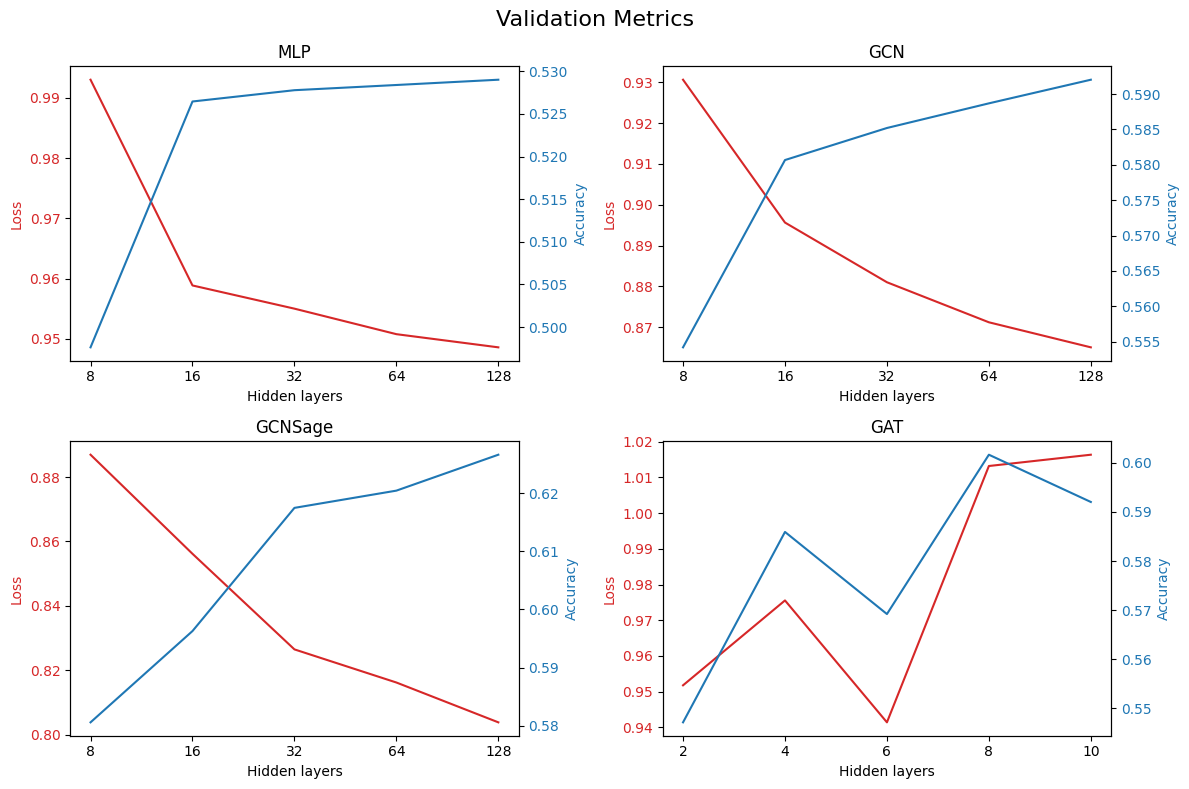

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (12,8))

color = 'tab:red'
ax[0][0].set_xlabel('Hidden layers')
ax[0][0].set_ylabel('Loss', color=color)
ax[0][0].plot(range(len(channel_vec)), MLP_loss, color=color)
ax[0][0].tick_params(axis='y', labelcolor=color)

ax[0][0].set_xticks(range(len(channel_vec)))
ax[0][0].set_xticklabels(channel_vec)

ax[0][0].set_title('MLP')

ax2 = ax[0][0].twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(len(channel_vec)), MLP_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:red'
ax[0][1].set_xlabel('Hidden layers')
ax[0][1].set_ylabel('Loss', color=color)
ax[0][1].plot(range(len(channel_vec)), GCN_loss, color=color)
ax[0][1].tick_params(axis='y', labelcolor=color)

ax[0][1].set_xticks(range(len(channel_vec)))
ax[0][1].set_xticklabels(channel_vec)

ax[0][1].set_title('GCN')

ax2 = ax[0][1].twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(len(channel_vec)), GCN_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)



color = 'tab:red'
ax[1][0].set_xlabel('Hidden layers')
ax[1][0].set_ylabel('Loss', color=color)
ax[1][0].plot(range(len(channel_vec)), GCNSage_loss, color=color)
ax[1][0].tick_params(axis='y', labelcolor=color)

ax[1][0].set_xticks(range(len(channel_vec)))
ax[1][0].set_xticklabels(channel_vec)

ax[1][0].set_title('GCNSage')

ax2 = ax[1][0].twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(len(channel_vec)), GCNSage_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)



color = 'tab:red'
ax[1][1].set_xlabel('Hidden layers')
ax[1][1].set_ylabel('Loss', color=color)
ax[1][1].plot(range(len(channel_vec_gat)), GAT_loss, color=color)
ax[1][1].tick_params(axis='y', labelcolor=color)

ax[1][1].set_xticks(range(len(channel_vec_gat)))
ax[1][1].set_xticklabels(channel_vec_gat)

ax[1][1].set_title('GAT')

ax2 = ax[1][1].twinx()

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(len(channel_vec_gat)), GAT_acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Validation Metrics', fontsize=16)
fig.tight_layout()
plt.show()

As we can see, the best performing model (in terms of accuracy) is almost always the one with the most hidden units. The dataset is fairly big, so it makes sense that the performances grew with the model complexity in this range.

The GAT architecture experienced a weird dip in accuracy with 6 channels. The loss also decreased so it probably overfitted a bit. In general this architecture seems a bit more complex to train, since the validation loss grew (unexpectedly) with the accuracy. The best GAT model here is the one with 8 hidden channels.

Let's select the best configuration for each architecture according to the validation accuracy and retrain them to make a comparison on the test set.

In [ ]:
# set parameters
learning_rate = 0.01
weight_decay  = 5e-4
epochs        = 200
patience = 15


models = []
losses = []
accuracies = []

# best model configurations
best_channels = [channel_vec[np.argmax(MLP_acc)], channel_vec[np.argmax(GCN_acc)], channel_vec[np.argmax(GCNSage_acc)], channel_vec_gat[np.argmax(GAT_acc)]]

# MLP---------------------------------------------------------------------------
print('MLP training-----------------------------------------------------------')
# empty unused memory
gc.collect()
torch.cuda.empty_cache()

# train the best MLP model
model = MLP(best_channels[0], data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience, verbose = False)
models.append(model)

# collect test metrics
loss, acc = test(model, data, loss_fn = F.nll_loss, metric = metric)
losses.append(loss)
accuracies.append(acc)

# GCN---------------------------------------------------------------------------
print('GCN training-----------------------------------------------------------')
# empty unused memory
gc.collect()
torch.cuda.empty_cache()

# train the best GCN model
model = GCN(best_channels[1], data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience, verbose = False)
models.append(model)

# collect test metrics
loss, acc = test(model, data, loss_fn = F.nll_loss, metric = metric)
losses.append(loss)
accuracies.append(acc)

# GCNSage-----------------------------------------------------------------------
print('GCNSage training-------------------------------------------------------')
# empty unused memory
gc.collect()
torch.cuda.empty_cache()

# train the best GCNSage model
model = GCNSage(best_channels[2], data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience, verbose = False)
models.append(model)

# collect test metrics
loss, acc = test(model, data, loss_fn = F.nll_loss, metric = metric)
losses.append(loss)
accuracies.append(acc)

# GAT---------------------------------------------------------------------------
print('GAT training-----------------------------------------------------------')
# empty unused memory
gc.collect()
torch.cuda.empty_cache()

# train the best GAT model
model = GAT(best_channels[3], data).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(model, data, loss_fn = F.nll_loss, optimizer = optimizer, metric = metric, patience = patience, verbose = False)
models.append(model)

# collect test metrics
loss, acc = test(model, data, loss_fn = F.nll_loss, metric = metric)
losses.append(loss)
accuracies.append(acc)

MLP training-----------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Early stopping. Restoring the model at epoch 112 with early stopping metric 0.5298.
GCN training-----------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

GCNSage training-------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

GAT training-----------------------------------------------------------


  0%|          | 0/200 [00:00<?, ?it/s]

Early stopping. Restoring the model at epoch 029 with early stopping metric 0.5843.


In [ ]:
# print summary metrics
pd.DataFrame({'Test Loss':losses, 'Test Accuracy': accuracies}, index = ['MLP', 'GCN', 'GCNSage', 'GAT'])

,Test Loss,Test Accuracy
MLP,0.948077,0.528886
GCN,0.864537,0.591506
GCNSage,0.805739,0.625663
GAT,0.982211,0.579249


As we can see, the best performing model is the GCNSage, with peak test accuracy and the lowest test loss. Meanwhile the worst performing model is the simple MLP (even though the GAT has an higher test loss), indicating that the network structure helped in this classification task.

Let's finish by plotting the test confusion matrices for each of these for 4 models to gain some more insights on their performances.

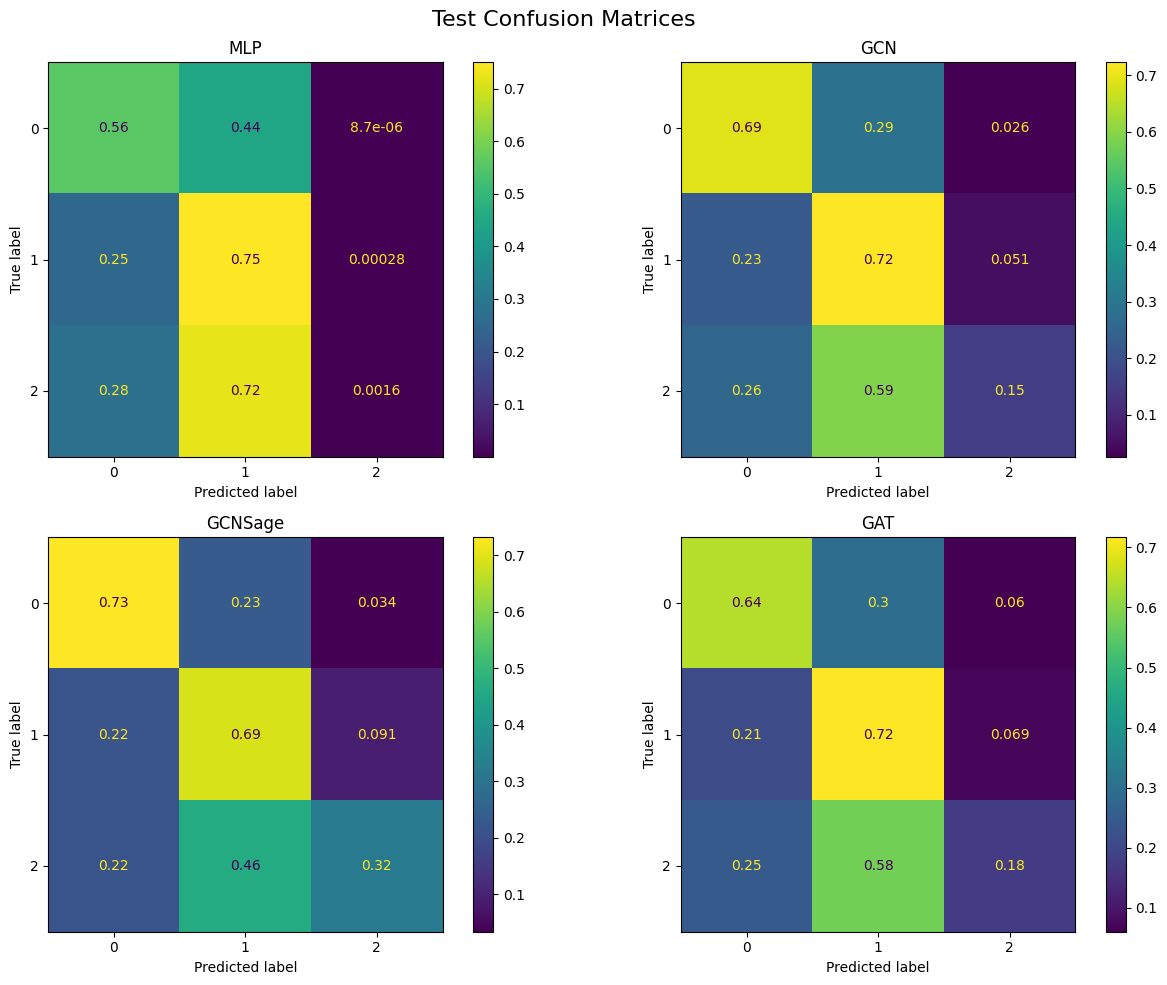

In [ ]:
actual = data.y[data.test_mask].cpu()
labels = range(3)

fig,ax = plt.subplots(2,2, figsize = (13,10))

# MLP---------------------------------------------------------------------------
predicted = models[0](data)[data.test_mask].argmax(dim = 1).cpu()
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[0][0], normalize = 'true')
ax[0][0].set_xticklabels(labels, rotation = 0)
ax[0][0].set_yticklabels(labels, rotation = 0)
ax[0][0].set_title('MLP')

# GCN---------------------------------------------------------------------------
predicted = models[1](data)[data.test_mask].argmax(dim = 1).cpu()
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[0][1], normalize = 'true')
ax[0][1].set_xticklabels(labels, rotation = 0)
ax[0][1].set_yticklabels(labels, rotation = 0)
ax[0][1].set_title('GCN')

# GCNSage-----------------------------------------------------------------------
predicted = models[2](data)[data.test_mask].argmax(dim = 1).cpu()
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[1][0], normalize = 'true')
ax[1][0].set_xticklabels(labels, rotation = 0)
ax[1][0].set_yticklabels(labels, rotation = 0)
ax[1][0].set_title('GCNSage')

# GAT---------------------------------------------------------------------------
predicted = models[3](data)[data.test_mask].argmax(dim = 1).cpu()
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, ax = ax[1][1], normalize = 'true')
ax[1][1].set_xticklabels(labels, rotation = 0)
ax[1][1].set_yticklabels(labels, rotation = 0)
ax[1][1].set_title('GAT')


fig.suptitle('Test Confusion Matrices', fontsize=16)
fig.tight_layout()
plt.show()

As we can see, the MLP, which performed the worst, was not able to recognize correctly the people Over 30. The GCN and the GAT did a better job of this, but the percentage of correctly recognized people in class 2 is still pretty low. The best performing model is by far the best at recognizing this underrepresented class, and performs equally well in the others.